<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_03_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

:Please note, it is necceesary to restart the session especially after the package downgrades for this code to work properly.

In [ ]:
# downgrade numpy
!pip uninstall numpy -y
!pip install numpy==1.26.4

# fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class
!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

# Uninstall and reinstall scipy and scikit-learn to ensure compatibility with the specified numpy version
!pip uninstall scipy -y
!pip uninstall scikit-learn -y
!pip install scipy
!pip install scikit-learn
!pip install wandb

In [ ]:
# mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

# Install Git Large File Storage (LFS) for handling large files in Git repositories
# !git lfs install

#Clone the Geneformer repository (commented out to avoid repeated cloning)
# !git clone https://huggingface.co/ctheodoris/Geneformer

# Navigate to the Geneformer directory
%cd Geneformer

# Install Geneformer package locally
# I found that installing Genformer first helped with a lot of the version conflict issues
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

print(numpy.__version__)

In [2]:
import pickle

# bulding the mapping dictionary

# Define class mapping: 0 = Parkinson's, 1 = Normal
new_id_class_dict = {
    0: "normal",
    1: "Parkinson_disease",
}

# Overwrite the existing mapping file
file_path = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(new_id_class_dict, f)

print("Mapping file saved.")

# Reload and print to confirm
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

print("Loaded class mapping:")
for k, v in loaded_dict.items():
    print(f"{k}: {v}")

Mapping file saved.
Loaded class mapping:
0: normal
1: Parkinson_disease


In [3]:
output_prefix = "park_classifier"

data_directory = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/'

output_dir = f"/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2"
!mkdir $output_dir

park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'

geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'

mkdir: cannot create directory ‘/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2’: File exists


##Fine-tune the model for cell state classification

In [4]:
from geneformer import Classifier
from transformers import TrainingArguments

hf_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1.5,                         # updated
    learning_rate= 5e-5,                       # updated
    lr_scheduler_type="polynomial",              # already correct
    warmup_steps=500,                            # updated
    weight_decay=0.25,                        # updated
    per_device_train_batch_size=8,              # updated
    seed=73,                                      # already correct
    bf16=True,                                    # preserved
    evaluation_strategy="epoch",                 # preserved
    save_strategy="epoch",                       # preserved
    load_best_model_at_end=True,                 # preserved
    metric_for_best_model="eval_loss",           # preserved
    greater_is_better=False,                     # preserved
    logging_dir=f"{output_dir}/logs",            # preserved
    logging_steps=50,                            # preserved
    report_to="none",                            # preserved
)

training_args_dict = hf_args.to_dict()

cc = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "disease_state", "states": "all"},
    training_args=training_args_dict,  # pass as dict, not object
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=1,
    forward_batch_size=32,
    nproc=16
)

print(cc.training_args["num_train_epochs"])  # should print 1.5

1.5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
from datasets import load_from_disk

original_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
original_data = load_from_disk(original_path)
print("Original dataset length:", len(original_data))

Original dataset length: 13533


In [6]:
#datsets imports for handling tokenized dataset
from datasets import load_dataset, load_from_disk, ClassLabel, concatenate_datasets
import numpy as np


#load the training data
park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
park_data = load_from_disk(park_data_path)

# Add an 'id' column that stores the original index
park_data = park_data.add_column("id", list(range(len(park_data))))

# Explicit class ordering: 0 = Normal, 1 = Parkinson's,
classes = ["normal","Parkinson_disease"]

# make the disease state column a classlabel
park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

park_data = park_data.rename_column("disease_state", "label")  # for compatibility with classifier_utils call in classifer.train_classifier

# get the test and eval splits
split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label") #establish train and eval with stratification

# check the label mapping
print("Label mapping:", park_data.features["label"])

# split test and eval
train_data = split_data['train']
eval_data = split_data['test']

### oversampling of the parkinsons cells for class balance during fine-tuning

# Split the dataset
normal = train_data.filter(lambda x: x['label'] == 0)
parkinson = train_data.filter(lambda x: x['label'] == 1)

# Calculate how many times to repeat Parkinson's samples
repeat_factor = len(normal) // len(parkinson)
extra = len(normal) % len(parkinson)

# Repeat and slice
parkinson_oversampled = parkinson.select(np.tile(range(len(parkinson)), repeat_factor).tolist())
if extra > 0:
    extra_samples = parkinson.select(np.random.choice(range(len(parkinson)), size=extra, replace=False).tolist())
    parkinson_oversampled = concatenate_datasets([parkinson_oversampled, extra_samples])

# Combine oversampled Parkinson's with normal class
train_data_balanced = concatenate_datasets([normal, parkinson_oversampled]).shuffle(seed=42)

# Update IDs
train_ids = train_data_balanced["id"]
train_data = train_data_balanced

# put the training and eval data back together for recall by the validate function as a file
park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
park_data = concatenate_datasets([train_data, eval_data])
park_data.save_to_disk(park_data_with_id_path)

print(len(park_data))
print(len(train_data))
print(len(eval_data))

# Get ids for dictionary construction
train_ids = train_data["id"]
eval_ids = eval_data["id"]

# generate dictionary for validate method
train_valid_id_split_dict = {"attr_key": "id",
                            "train": train_ids,
                            "eval": eval_ids}

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Label mapping: ClassLabel(names=['normal', 'Parkinson_disease'], id=None)


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


21245
18538
2707


In [7]:
import os
import torch
torch.cuda.empty_cache()

os.environ["WANDB_DISABLED"] = "true"

# fine tune the model
all_metrics = cc.validate(model_directory=geneformer_directory,
                          prepared_input_data_file = park_data_with_id_path,
                          id_class_dict_file= '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl',
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.1

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.001900,0.011543,0.998153,0.996251


/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


  0%|          | 0/85 [00:00<?, ?it/s]

In [9]:
all_metrics

{'conf_matrix':                    normal  Parkinson_disease
 normal             2315.0                3.0
 Parkinson_disease     2.0              387.0,
 'macro_f1': [0.9962513830554759],
 'acc': [0.9981529368304396],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.99485861, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99814235,
         0.99934616, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1. 

##Evaluate the model

In [16]:
#add ids to the test data

#load the test data
park_data_test_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_tokenized.dataset/'
park_data_test = load_from_disk(park_data_test_path)

# Add an 'id' column that stores the original index
park_data_test = park_data_test.add_column("id", list(range(len(park_data_test))))

# Explicit class ordering: 0 = Normal, 1 = Parkinson's,
classes = ["normal","Parkinson_disease"]

# make the disease state column a classlabel
park_data_test = park_data_test.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

#rename the disease_state column as label

park_data_test = park_data_test.rename_column("disease_state", "label")

# save it back to disk

park_data_test_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_labeled_tokenized.dataset/'

park_data_test.save_to_disk(park_data_test_with_id_path)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Casting the dataset:   0%|          | 0/3561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3561 [00:00<?, ? examples/s]

In [17]:
#saved previous model locations due to gpu memory issues

current_model = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2/250605_geneformer_cellClassifier_park_classifier/ksplit1/'
current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
test_data_file = park_data_test_with_id_path
output_dir = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2/'
output_prefix = "park_classifier"

In [18]:
from geneformer import Classifier

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                forward_batch_size=36,
                nproc=16)

In [19]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=current_model,
        id_class_dict_file=current_dict,
        test_data_file = test_data_file,
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/99 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

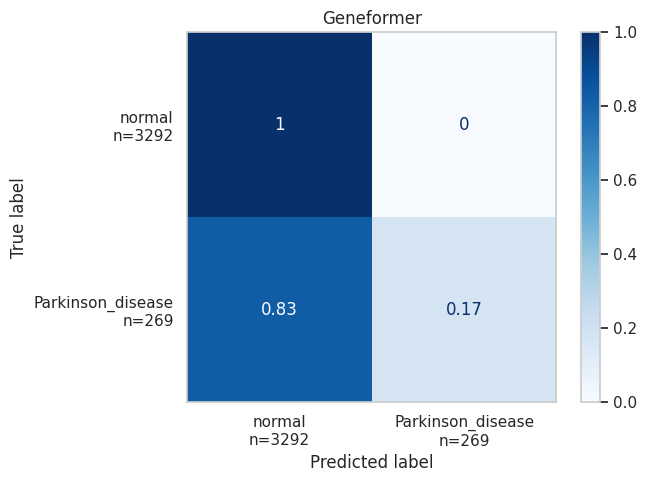

In [20]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
)

<Figure size 1500x1500 with 0 Axes>

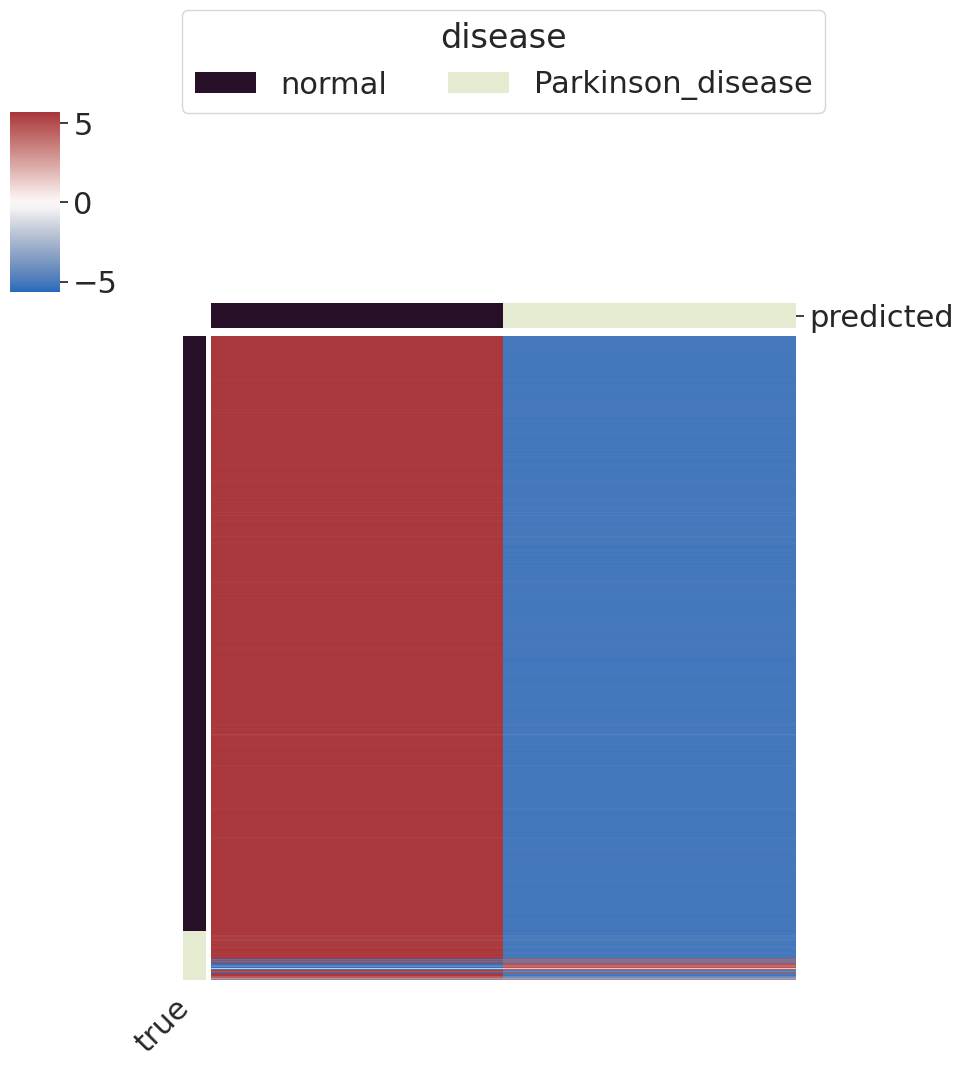

In [21]:
cc.plot_predictions(
    predictions_file=f"{output_dir}{output_prefix}_pred_dict.pkl",
    id_class_dict_file = current_dict,
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
)